In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
# 0. define the paramters of the exercise we'll do here
WN = 10000 # number of words in our vocabulary
N = 20000 # number of real data observations we have
#dataframe with information on the various features
feat_info = pd.DataFrame({
    'cols':  ['at_most_5_letters', 'ends_with_y', 'repeat_3_letters'],  # the feature columns
    'probs': [.5, .3, .2], # how likely each feature is to show up
    'coefs': [0, -1, 1] # how much each coef affects the probability of usage
}).set_index('cols')

In [3]:
# 1. define the words.  each row is a word.
# randomly generate words.  features are assumed IID with probability feat_probs
words_df = pd.DataFrame({c:np.random.binomial(1,feat_info.loc[c,'probs'], size=WN)
                          for c in feat_info.index})
# generate the score of each word.  this is where the feat_coefs comes in
words_df['p'] = np.exp(pd.DataFrame({c:feat_info.loc[c,'coefs']*words_df[c] 
                                        for c in feat_info.index}).sum(axis=1))
words_df['p'] /= words_df['p'].sum()

In [4]:
# 2. the real data
N_real = N # number of real data points to draw from true distribution
words_df['obs_real'] = np.random.multinomial(N_real, words_df['p'])

In [5]:
# 3. generate fake data
nu = 1 # multiplier for how many observations of fake data we'll generate relative to N
N_fake = int(N*nu) # number of fake data points to draw from fake distribution (=uniform)
fake_dist = np.array([1/WN]*WN)
words_df['obs_fake'] = np.random.multinomial(N_fake, fake_dist)

In [6]:
# 4. get everything into a format for logistic regression
#  we're going to combine the real and fake data
feat_cols = ['at_most_5_letters', 'ends_with_y', 'repeat_3_letters']
all_data = pd.concat([words_df[feat_cols+['obs_real']].rename(columns={'obs_real':'obs'}).assign(is_real=1),
                      words_df[feat_cols+['obs_fake']].rename(columns={'obs_fake':'obs'}).assign(is_real=0)
                     ])

In [7]:
# 5. train a model to distinguish between the real and the fake data
lm = LogisticRegression(C=10000) # no regularization
lm.fit(all_data[feat_cols], all_data['is_real'], sample_weight = all_data['obs'])
# print(lm.intercept_, lm.coef_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# 6. print the estimated coefs, compare with the real coefs.  they should be close
feat_info['coefs_estimated'] = lm.coef_[0]
feat_info[['coefs', 'coefs_estimated']]

,coefs,coefs_estimated
cols,,
at_most_5_letters,0,-0.018022
ends_with_y,-1,-0.997093
repeat_3_letters,1,0.981128


In [9]:
# 7. generate the estimated probabilities for each word
words_df['p_estimated'] = lm.predict_proba(words_df[feat_cols])[:,1] 
words_df['p_estimated'] = words_df['p_estimated']/(1-words_df['p_estimated']) * nu * fake_dist

sum of true probabilities: 1.000
sum of estimated probabilities: 1.001
sum of abs(p - p_estimated): 9.8e-03


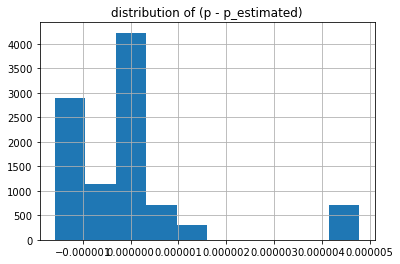

In [10]:
# 8. print some statistics
words_df['err'] = words_df['p']-words_df['p_estimated']
words_df['err'].hist()
plt.title("distribution of (p - p_estimated)")
print('sum of true probabilities: {:.3f}'.format(words_df['p'].sum()))
print('sum of estimated probabilities: {:.3f}'.format(words_df['p_estimated'].sum()))
print('sum of abs(p - p_estimated): {:.1e}'.format(np.abs(words_df['err']).sum()))